In [1]:
import h5py
from pathlib import Path
import numpy as np

from src.datasets.brainwidemap.utils import *

import pynapple as nap

from one.api import ONE

In [2]:
data_dir = Path("/projects/bdrz/yzhang39/brainwidemap/")

one = ONE(
    base_url="https://openalyx.internationalbrainlab.org",
    password="international", 
    silent=True,
    cache_dir=data_dir / "raw",
)

In [3]:
eid = "15763234-d21e-491f-a01b-1238eb96d389"
params = {
    "interval_len": 1, 
    "binsize": 0.02, 
    "single_region": False,
    "align_time": "stimOn_times", 
    "time_window": (-.2, .8), 
    "behavior_keys": ["choice", "block", "reward", "wheel"],
}

In [4]:
neural_dict, meta_dict, trials_data, behavior_data = prepare_data(one, eid, params)

(S3) /projects/bdrz/yzhang39/brainwidemap/raw/zadorlab/Subjects/CSH_ZAD_026/2020-09-04/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.79M/7.79M [00:00<00:00, 20.6MB/s]


In [6]:
trial_times = trials_data["trials_df"][params["align_time"]]
start = trial_times + params["time_window"][0]
end = trial_times + params["time_window"][1]
intervals = nap.IntervalSet(start=start, end=end)

In [7]:
cluster_ids = np.unique(neural_dict["spike_clusters"])

spikes = nap.TsGroup({
    cluster_id: nap.Ts(
        t=neural_dict["spike_times"][neural_dict["spike_clusters"] == cluster_id]
    ) for cluster_id in cluster_ids
})

In [8]:
binned_spikes = nap.build_tensor(
    spikes, intervals, bin_size=0.01
).transpose(1, 2, 0)
binned_spikes.shape # (n_trials, n_bins, n_clusters)

(894, 100, 910)

/tmp/ipykernel_1181889/1912899491.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc='lower right')


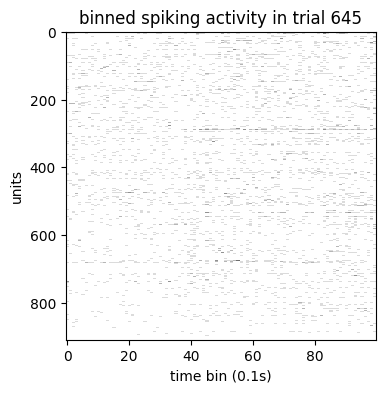

In [9]:
from matplotlib import pyplot as plt

trial = 645
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(
    binned_spikes[trial].T,
    aspect='auto',
    cmap=plt.cm.gist_yarg,
    interpolation='none',
)
ax.set_ylabel('units')
ax.set_xlabel('time bin (0.1s)')
ax.legend(frameon=False, loc='lower right')
ax.set_title(f'binned spiking activity in trial {trial}');

In [ ]:
behavior_key = "wheel"
behavior = nap.Tsd(
    t=behavior_data[behavior_key]["times"], 
    d=behavior_data[behavior_key]["values"],
)
binned_behavior = nap.build_tensor(
    behavior, intervals, bin_size=params["binsize"]
)
print(binned_behavior.shape)  # (n_trials, n_bins)

(894, 1000)


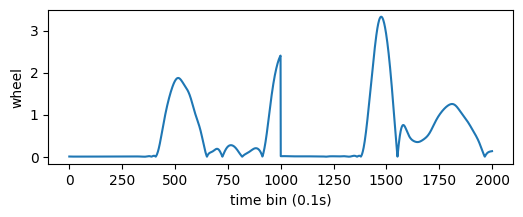

In [27]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(binned_behavior.flatten()[:2_000])
ax.set_ylabel(behavior_key)
ax.set_xlabel('time bin (0.1s)');

In [38]:
# Save as HDF5 file
with h5py.File(data_dir / "precached" / f"{eid}.h5", "w") as f:
    f.create_dataset("spikes", data=binned_spikes)
    meta_grp = f.create_group("metadata")
    for k, v in meta_dict.items():
        meta_grp.attrs[k] = v

In [40]:
# Load HDF5 file
with h5py.File(data_dir / "precached" / f"{eid}.h5", "r") as f:
    spikes = f["spikes"][:]
    metadata = dict(f["metadata"].attrs)
print(f"Loaded spikes shape: {spikes.shape}")
print(f"Metadata keys: {metadata.keys()}")

Loaded spikes shape: (894, 100, 910)
Metadata keys: dict_keys(['cluster_channels', 'cluster_regions', 'eid', 'good_clusters', 'lab', 'subject', 'uuids'])


##### Load Dataset

In [1]:
from src.configs.run import RunConfig
from src.configs.model import ModelConfig, EncoderConfig, DecoderConfig
from src.configs.data import DataConfig
from src.configs.trainer import TrainingConfig
from src.utils.dataset import BaseDataset

base_path="/projects/bcxj/yzhang39/brainwidemap"
log_path=f"{base_path}/logs"
checkpoint_path=f"{base_path}/checkpoints"

run_config = RunConfig(
    id = "debug",
    model = ModelConfig(),
    data = DataConfig(),
    training = TrainingConfig(max_epochs=1),
    log_path=log_path,
    checkpoint_path=checkpoint_path,
    data_path=base_path,
)

data_config = run_config.data

In [2]:
dataset = BaseDataset(
    run_config.data_path,
    partition=data_config.train_partition,
    selected_cols=["spikes"],
    config=data_config,
)

In [6]:
dataset.__getitem__(0).keys()  # Test if the dataset can be accessed

dict_keys(['spikes', 'spikes_timestamps', 'spikes_spacestamps', 'spikes_time_attn_mask', 'spikes_space_attn_mask', 'eid', 'cluster_regions', 'uuids', 'lab', 'subject'])